<a href="https://colab.research.google.com/github/szalmaf/AlphaGo/blob/master/To0620_Transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Deep Neural Networks
Transfer learning with  PyTorch [Lightning](https://www.pytorchlightning.ai)

In [1]:
%%capture
!pip install pytorch-lightning
!pip install pytorch-lightning-bolts==0.2.5rc1

## Case 1: Supervised transfer learning

In [2]:
from torchvision import models
import torch

# Residual deep neural network
resnet50 = models.resnet50(pretrained=True)
resnet50.fc = torch.nn.Linear(resnet50.fc.in_features, 10) # Swap out resnet's fc layer for a linear layer w/ 10 features

### Deep learning standardized **image data sets**:

* [**MNIST**](http://yann.lecun.com/exdb/mnist/) - 10 digits: 1, 2, ..., 10
* [**CIFAR10**](https://www.cs.toronto.edu/~kriz/cifar.html) - 10 classes of 6,000 32x32 color images in each class  
* [**ImageNet**](http://www.image-net.org) - 1000 classes, 1000 images in each class

In [3]:
from torchvision.datasets import CIFAR10
from torchvision import transforms

# Normalize rgb channels separately
normalize = transforms.Normalize(mean=[x/255. for x in [125.3, 123., 113.9]],
                                 std=[x/255. for x in [63., 62.1, 66.7]])
cf10_transforms = transforms.Compose([
                                      transforms.ToTensor(),
                                      normalize
])
cifar_10 = CIFAR10('.', train=True, download=True, transform=cf10_transforms)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label: label


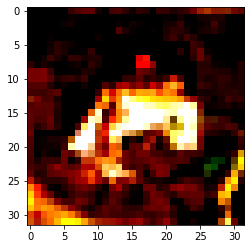

In [4]:
from matplotlib import pyplot as plt

image, label = next(iter(cifar_10))

print("Label: label")

img = image.numpy().transpose(1,2,0)
plt.imshow(img)

(array([ 29., 257., 622., 637., 540., 519., 189., 130., 101.,  48.]),
 array([-1.9888889 , -1.5806602 , -1.1724316 , -0.7642029 , -0.35597426,
         0.05225438,  0.460483  ,  0.86871165,  1.2769403 ,  1.685169  ,
         2.0933976 ], dtype=float32),
 <a list of 10 Patch objects>)

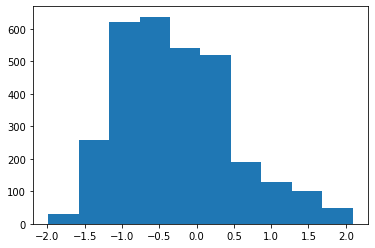

In [5]:
plt.hist(img.flatten())

In [6]:
from torch.utils.data import DataLoader

train_loader = DataLoader(cifar_10, batch_size=32, shuffle=True)

for batch in train_loader:
  x, y = batch
  print(x.shape, y.shape)
  break

torch.Size([32, 3, 32, 32]) torch.Size([32])


In [7]:
x, y = next(iter(train_loader))

preds = resnet50(x)
print(preds.shape)
preds[:5]

torch.Size([32, 10])


tensor([[ 0.4935, -0.0445, -0.4511,  0.0305, -0.0061,  0.0959,  0.3940,  0.2479,
          0.1378,  0.0821],
        [-0.0496, -0.6209,  0.1683, -0.1420, -0.5210, -0.2254, -0.0028,  0.0254,
          0.3616,  0.4889],
        [-0.3720,  0.0431, -0.3786,  0.3742, -0.4795,  0.3551,  0.8952, -0.6006,
          0.2348,  0.4721],
        [ 0.3538, -0.0858, -0.7956,  0.3363, -0.8372,  0.2047,  0.8912,  0.1782,
         -0.2451,  0.1603],
        [ 0.4868,  0.3121,  0.0199,  0.0418,  0.0809, -0.2781,  0.5078, -0.4317,
          0.1894, -0.3169]], grad_fn=<SliceBackward>)

In [8]:
from torch.nn.functional import softmax

preds = softmax(preds, dim=-1)

In [9]:
preds[:5]

tensor([[0.1443, 0.0842, 0.0561, 0.0908, 0.0875, 0.0969, 0.1306, 0.1129, 0.1011,
         0.0956],
        [0.0950, 0.0536, 0.1181, 0.0866, 0.0593, 0.0797, 0.0995, 0.1024, 0.1433,
         0.1627],
        [0.0585, 0.0886, 0.0581, 0.1234, 0.0525, 0.1211, 0.2078, 0.0466, 0.1073,
         0.1361],
        [0.1245, 0.0802, 0.0394, 0.1223, 0.0378, 0.1072, 0.2131, 0.1044, 0.0684,
         0.1026],
        [0.1460, 0.1226, 0.0915, 0.0935, 0.0973, 0.0679, 0.1491, 0.0583, 0.1084,
         0.0654]], grad_fn=<SliceBackward>)

In [10]:
pred_labels = torch.argmax(preds[:10], dim=-1)
pred_labels

tensor([0, 9, 6, 6, 6, 1, 9, 6, 9, 6])

In [11]:
y[:10]

tensor([8, 6, 9, 0, 1, 8, 6, 0, 5, 4])

In [12]:
backbone = models.resnet50(pretrained=True)

In [13]:
fc = torch.nn.Linear(backbone.fc.out_features, 10)

In [14]:
from pl_bolts.datamodules import CIFAR10DataModule

dm = CIFAR10DataModule('.')

### Supervised transfer learning with PyTorch

In [ ]:
from torch.nn.functional import cross_entropy
from torch.optim import Adam

optimizer =  Adam(fc.parameters(), lr=1e-4)
for epoch in range(10):
  for batch in dm.train_dataloader() : # Mix Bolts and PyTorch
    x, y = batch

    ## Forward ##
    with torch.no_grad(): 
      # Freeze backbone
      # (b, 3, 32, 32) -> (b, 1000)
      features = backbone(x)
    # (b, 1000) -> (b, 10)
    # Train fc fully connected layer only 
    preds = fc(features)
    loss = cross_entropy(preds, y)

    ## Backward ##
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    print(loss.item())